## Load the packages and grid etc.

In [24]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the curre nt kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/prep_grid_aste_90.py"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(450, 90)
RAC2d (40500,)
(100,)


In [25]:
dirroot = "/scratch3/atnguyen/aste_90x150x60/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
runstr= "run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/"
layers_path = dirroot + runstr
extL = "LAYERS"
dirmask = dirroot + "run_template/input_maskTransport/"
dirbudg = layers_path + "diags/BUDG/"
dirdiags = dirbudg
dirstate = layers_path + "diags/STATE/"
dirlayers = layers_path + "diags/LAYERS/"
dirtrsp = layers_path + "diags/TRSP/"

In [26]:
# try to use rdmds
fileprefix = "/scratch3/atnguyen/aste_90x150x60/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v2_mskBasin.bin"
ind = np.fromfile(filename, dtype=np.int32)  # auto-reads .meta for shape/dtype/order
orig_shape = (ind.shape)

ind2d = ind.reshape(ny,nx)

mymsk = np.full((ny,nx),np.nan)
mymsk[ind2d == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

ind = ind.reshape(ny,nx)
mymsk = np.full((ny,nx),np.nan)
mymsk[ind == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

In [27]:
landmsk = np.zeros((ny,nx))
landmsk[hf1 == 0] = 1
landmsk[hf1 == 1] = np.nan

## pick a mask and the "gates" -- be on face 3 to verify

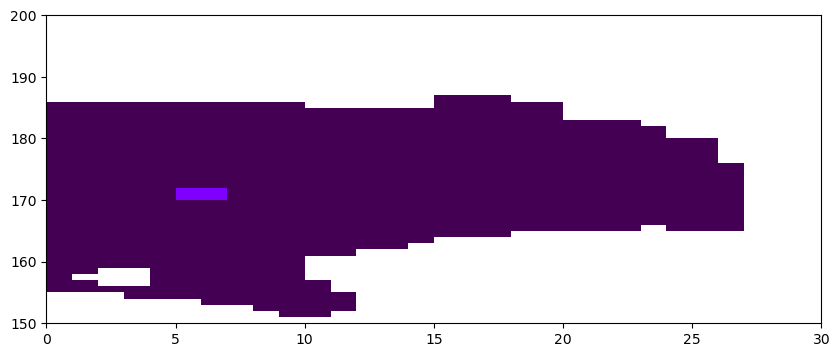

In [28]:
# plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])

# we will work on face 3 -- pick our four points
plt.ylim(150,200)
plt.xlim(0,30)
mymsk2 = np.zeros_like(mymsk)
mymsk2[170:172,5:7] = 1
mymsk2[170:172,5:7] = 1

mymsk2[mymsk2==0] = np.nan

plt.pcolormesh(mymsk)
plt.pcolormesh(mymsk2,cmap='rainbow')

In [70]:
# define the gates as part of a dict
print(np.where(mymsk2==1))

gg = {}

# top gate (j+1)
yg1,xg1 = np.array([172,172]),np.array([5,6])  # where we READ from
# bottom gate (j)
yg2,xg2 = np.array([170,170]),np.array([5,6])

# left gate (i)
yg3,xg3 = np.array([170,171]),np.array([5,5])
# right gate (i+1)
yg4,xg4 = np.array([170,171]),np.array([7,7])  # where we READ from

ys_all = np.array([yg1,yg2,yg3,yg4])
xs_all = np.array([xg1,xg2,xg3,xg4])

# add these to the dict
gnames = np.array(["g1","g2","g3","g4"])
i = 0
for name in gnames:
    # top, bottom, left, right
    gg[name] = {}
    gg[name]["yg"] = ys_all[i]
    gg[name]["xg"] = xs_all[i]
    # for the sign
    if i == 0 or i == 2:
        sign = -1
        gg[name]['sign'] = sign
    else:
        gg[name]['sign'] = 1
    # for reading advx or advy
    if i == 0 or i == 1:
        read = "y"
        gg[name]['read'] = read
    else:
        gg[name]['read'] = "x"
    i += 1

(array([170, 170, 171, 171]), array([5, 6, 5, 6]))


## Load all the terms to show that this is budgeted in T-S space

In [41]:
# bbb.boundsT=squeeze(rdmds([dirrun 'layers2TH']))'; bbb.nT=length(bbb.boundsT)-1;
# bbb.boundsS=squeeze(rdmds([dirrun 'layers1SLT']))';bbb.nS=length(bbb.boundsS)-1;
# bbb.binwidthT=(bbb.boundsT(2:end)-bbb.boundsT(1:end-1));
# bbb.binwidthS=(bbb.boundsS(2:end)-bbb.boundsS(1:end-1));

# bbb.binwidthT1=0.5.*(bbb.binwidthT(2:end)+bbb.binwidthT(1:end-1)); %same as diff(bbb.binmidT)
# bbb.binwidthS1=0.5.*(bbb.binwidthS(2:end)+bbb.binwidthS(1:end-1)); %same as diff(bbb.binmidS)
# bbb.binmidT=(bbb.boundsT(2:end)+bbb.boundsT(1:end-1))./2;
# bbb.binmidS=(bbb.boundsS(2:end)+bbb.boundsS(1:end-1))./2;
# nT=bbb.nT;nS=bbb.nS;nTm1=bbb.nT-1;nSm1=bbb.nS-1;

# try to replicate exactly the An way
boundsT = np.squeeze(rdmds(layers_path + "layers2TH")).ravel()
nT = boundsT.size - 1
boundsS = np.squeeze(rdmds(layers_path + "layers1SLT")).ravel()
nS = boundsS.size - 1

binwidthT = boundsT[1:] - boundsT[:-1]
binwidthS = boundsS[1:] - boundsS[:-1]

binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1])
binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])

binmidT = (boundsT[1:] + boundsT[:-1]) /2
binmidS = (boundsS[1:] + boundsS[:-1]) /2

nT = nT
nS = nS
nTm1 = nT-1
nSm1 = nS-1

### do for temperature first

In [35]:
# we need to also create the theta and salt bins for this area
tsstr = np.array(["0000000002","0000000003"])
t2 = int(tsstr[1]) # for the offline version

In [36]:
# first just load the ADVh and ADVr terms for temperature
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["ADVr_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)

hf = mygrid['hFacC']

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_TH.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhT = ADV_hconv

trWtopADV = -(ADVr_TH)

ADVrT = np.zeros((nz,ny,nx),dtype=float)
ADVrT[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])  # this is not the way we did it in the original code but this is the way An has done it so we try

In [163]:
# load the temperature and salt for this timestep
# maybe the order of binning is wrong, we're binning at T2 for the effects throughout T1
# I think this is not the correct way to do things -- reread theta and do binning by volume here
t2 = int(tsstr[1])
t1 = int(tsstr[0])
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA2,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
THETA1,its,meta = rdmds(os.path.join(dirstate, file_name),t1,returnmeta=True,rec=recs[0])  # this is what we want to bin by, NOT the ttend

In [164]:
THETA2 = THETA2.reshape((nz,ny,nx))

## Make sure we show the ADVh in T and S -- is the volume transport the same

In [142]:
ffac=1e-6
G_T=np.array([])
metaT=parsemeta(layers_path + "diags/LAYERS/layers_3d_Ttend." + "0000000003" + ".meta")
nFldsT = metaT["fldList"]
print(len(nFldsT))
setTtend=nFldsT.copy()


# check for the correct diagnostics
metaT['fldList']   # 13, 14, 15, 16, 19, 22
b = metaT['fldList']
ifldT = np.array([1,2])    # surf, hDiff, vDiff, hADV, vADV, total tend
# print(np.array(b)[ifldT])  # for G_T

# remake the following to look for the existing terms and see if we can recreate
# ['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']
ifldT = np.array([0,1,2,7,8,11])
print(np.array(b)[ifldT])  # for G_T

# get the indices
fileprefix = "/scratch3/atnguyen/aste_90x150x60/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v2_mskBasin.bin"
ind = np.fromfile(filename, dtype=np.int32)  # auto-reads .meta for shape/dtype/order
print(ind.shape)
orig_shape = (ind.shape)
orig_shape = (ind.shape)
mymsk_1d = mymsk2.reshape(orig_shape, order='C')
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

mymsk_1d = mymsk2.reshape(orig_shape, order='C')
mymsk_1dtile = np.tile(mymsk_1d[np.newaxis,:],(nT-1,1))

# mymsk3d.shape
# hf2dtile.shape
iwet_mine = np.where(~np.isnan(mymsk_1d))
iwet_mine[0].shape
iwet_mine = iwet_mine[0]   # this is already the 1D array of wetpoints to use, we can add these below by indexing

# make the G_T term
# we did not mask this or the other one which is why they are the same
# try to make sure we maskt this here.

name = "BarentsS"
G_T = {}
G_T[name] = {}
ts = tsstr[1]
    
# now loop through
G_T[name][ts] = {}
for i in range(len(ifldT)-1, -1, -1):
    tmp = read_float64_skip(layers_path + "diags/LAYERS/layers_3d_Ttend." + tsstr[-1] + ".data", nx*ny*(nT-1),ifldT[i])
    tmp = np.reshape(tmp,(nT-1,nx*ny))
    tmp = tmp * (rac2dtile * hf2dtile) #* ffac

    if i == ifldT.shape[0]-1:
        # if LTto2TH, do not remove from residual
        residT = tmp
    else:
        # else if vADV, hADV, vDiff, hDiff, surface, remove from residual
        residT = residT-tmp
    
    # just do the Barents Sea for this one
    a = np.nansum(tmp[:,iwet_mine],axis=1)   # was iwet_mine
    G_T[name][ts][setTtend[ifldT[i]]] = a

# residT was wrong here so we can just ignore

24
['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']
(40500,)


In [143]:
mymsk3d = np.tile(mymsk2[np.newaxis,:,:],(nz,1,1))
hf1.shape
hf= np.tile(hf1[np.newaxis,:,:],(nz,1,1))

In [228]:
# define the ADVh total for this mymsk2
G_T_offline_new = np.zeros((2, nT-1))
dF_Tnew = np.zeros((2, nT-1))
Lijnew = np.zeros((2, nT-1), dtype=int)

# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
T_flat    = np.ravel(THETA2*hf* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhT*hf* mymsk3d,  order='F')
ADVr_flat = np.ravel(ADVrT*hf* mymsk3d,  order='F')

for i in range(nT-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((T_flat >= binmidT[i]) & (T_flat < binmidT[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        dF_Tnew[0, i] = np.nansum(ADVh_flat[ij])
        dF_Tnew[1, i] = np.nansum(ADVr_flat[ij])

# MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
G_T_offline_new = dF_Tnew / binwidthT1[None, :]

Text(0, 0.5, 'm^3/s')

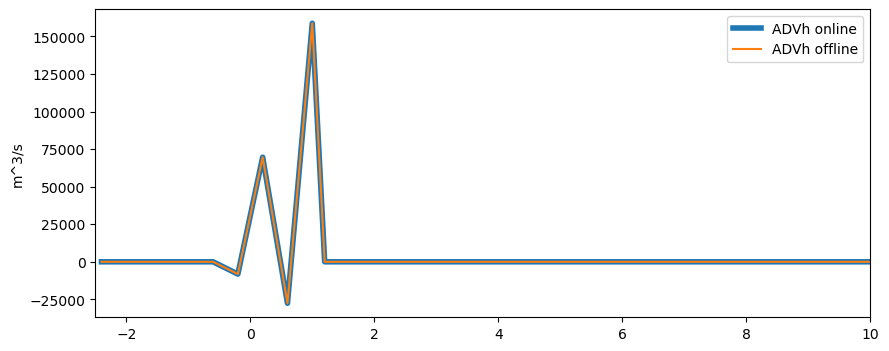

In [229]:
fig = plt.figure()

ax = plt.subplot(111)
ax.set_xlim(-2.5,10)

ax.plot(boundsT.flatten()[1:-1],G_T['BarentsS'][ts]['LTha2TH'],linewidth=4,label='ADVh online')
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0],label='ADVh offline')
ax.legend()
ax.set_ylabel("m^3/s")

In [230]:
print(np.nansum(G_T_offline_new[0]),"m^3/s")

192613.01311140292 m^3/s


In [231]:
gg

{'g1': {'yg': array([172, 172]), 'xg': array([5, 6]), 'sign': -1, 'read': 'y'},
 'g2': {'yg': array([170, 170]), 'xg': array([5, 6]), 'sign': 1, 'read': 'y'},
 'g3': {'yg': array([170, 171]), 'xg': array([5, 5]), 'sign': -1, 'read': 'x'},
 'g4': {'yg': array([170, 171]), 'xg': array([7, 7]), 'sign': 1, 'read': 'x'}}

## compare this to the M1 + M2 + M3 + M4 for the four gates to this 2x2. is it the same?

In [232]:
ADVx_TH = ADVx_TH.reshape((nz,ny,nx))
ADVy_TH = ADVy_TH.reshape((nz,ny,nx))

In [233]:
gg.keys()

dict_keys(['g1', 'g2', 'g3', 'g4'])

In [234]:
# start with top -- create the M term in 3D
# top, bottom, right, left
THETA_theta = THETA2.copy()
hFacC = mygrid['hFacC']

# define the ADVh total for this mymsk2
M_gates = np.zeros((4, nT-1))
# M_gates_new = np.zeros((4, nT-1))
Lijnew = np.zeros((4, nT-1), dtype=int)

gi = 0
for name in gnames:
    # define the depth vs length gate array and make sure to add it correctly
    print(name,gg[name]['yg'],gg[name]['xg'])
    if name == "g1":
        faceT = 0.5 * (THETA_theta[:,gg[name]['yg'],gg[name]['xg']] + THETA_theta[:,gg[name]['yg']-1,gg[name]['xg']])
        myadv = -ADVy_TH[:,gg[name]['yg'],gg[name]['xg']] #/ faceT   # degC.m^3/s
    elif name == "g2":
        faceT = 0.5 * (THETA_theta[:,gg[name]['yg'],gg[name]['xg']] + THETA_theta[:,gg[name]['yg']-1,gg[name]['xg']])
        myadv = ADVy_TH[:,gg[name]['yg'],gg[name]['xg']] #/ faceT   # degC.m^3/s
    elif name == "g3":
        faceT = 0.5 * (THETA_theta[:,gg[name]['yg'],gg[name]['xg']] + THETA_theta[:,gg[name]['yg'],gg[name]['xg']-1])
        myadv = ADVx_TH[:,gg[name]['yg'],gg[name]['xg']] #/ faceT   # degC.m^3/s
    elif name == "g4":
        faceT = 0.5 * (THETA_theta[:,gg[name]['yg'],gg[name]['xg']] + THETA_theta[:,gg[name]['yg'],gg[name]['xg']-1])
        myadv = -ADVx_TH[:,gg[name]['yg'],gg[name]['xg']] #/ faceT   # degC.m^3/s

    # flatten these
    Tflat = np.ravel(faceT)
    advflat = np.ravel(myadv)

    # bin by face theta and add to M_gates
    for i in range(nT-1):
        ij = np.where((Tflat >= binmidT[i]) & (Tflat < binmidT[i + 1]))[0]
        Lijnew[gi, i] = len(ij)
    
        if len(ij) > 0:
            # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
            M_gates[gi, i] = np.nansum(advflat[ij])
    gi += 1

# divide by binwidthT to get m^3/s
M_T_offline_new = M_gates #/ binwidthT1[None, :]  # m^3/s

g1 [172 172] [5 6]
g2 [170 170] [5 6]
g3 [170 171] [5 5]
g4 [170 171] [7 7]


Text(0, 0.5, 'm^3/s')

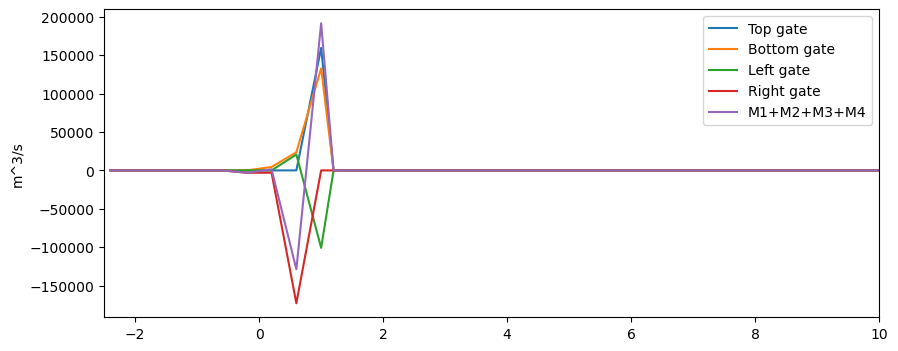

In [235]:
fig = plt.figure()

ax = plt.subplot(111)
ax.set_xlim(-2.5,10)

ax.plot(boundsT.flatten()[1:-1],M_T_offline_new[0],label='Top gate')
ax.plot(boundsT.flatten()[1:-1],M_T_offline_new[1],label='Bottom gate')
ax.plot(boundsT.flatten()[1:-1],M_T_offline_new[2],label='Left gate')
ax.plot(boundsT.flatten()[1:-1],M_T_offline_new[3],label='Right gate')

ax.plot(boundsT.flatten()[1:-1],np.nansum(M_T_offline_new,axis=0),label='M1+M2+M3+M4')

ax.legend()
ax.set_ylabel("m^3/s")

Text(0, 0.5, 'm^3/s')

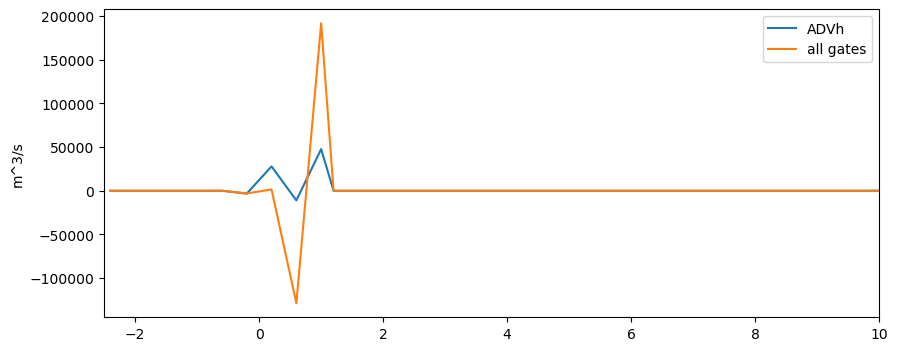

In [223]:
fig = plt.figure()

ax = plt.subplot(111)
ax.set_xlim(-2.5,10)

ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0],label='ADVh')
ax.plot(boundsT.flatten()[1:-1],np.nansum(M_T_offline_new,axis=0),label='all gates')
# ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[1],label='ADVr')
ax.legend()
ax.set_ylabel("m^3/s")

In [237]:
# these are the same!! only if we don't normalize by binwidthT1, why??

# because we are not transporting into the same T bins, again. we are transporting the same amount of heat though
# we can show this below (ADVhconv of heat and M transported heat through the gates is the same.

In [238]:
print(np.nansum(dF_Tnew[0]),np.nansum(np.nansum(M_T_offline_new,axis=0)))  # in degC.m^3/s, without normalizing

61170.143541721736 61170.14354172169


In [240]:
'''

How would we show this in a budget? We could create all of the terms without normalizing by binwidthT1 or binwidthS1.

We would have to show that in a basin, the contribution to heat or salt is the same, effectively before we even create the terms.

Not sure yet how to show this in a figure but we continue.

'''

'\n\nHow would we show this in a budget? We could create all of the terms without normalizing by binwidthT1 or binwidthS1.\n\nWe would have to show that in a basin, the contribution to heat or salt is the same, effectively.\n\nNot sure yet how to show this in a figure but we continue.\n\n'

## debugging

In [225]:
a = 0
for i in range(4):
    print(np.nansum(M_T_offline_new[i]))
    a += np.nansum(M_T_offline_new[i])

159563.53827405456
161013.61439204874
-80218.10627076669
-179188.90285361488


In [181]:
a

312613.6359181895

In [182]:
ADVhT.shape

(50, 450, 90)

In [184]:
gg['g1']['yg']

array([172, 172])

In [186]:
gg['g1']['xg']

array([5, 6])

In [189]:
np.nanmean(binwidthT1)

0.3770270272418185

In [201]:
samp = ADVhT[0] * mymsk2
np.nansum(samp)  # at the first layer in ADVhT, this is the sum

5201.518536721509

In [208]:
yg4

array([170, 171])

In [209]:
print(np.nansum(-ADVy_TH[np.array([0,0]),yg1,xg1]))
print(np.nansum(ADVy_TH[np.array([0,0]),yg2,xg2]))

print(np.nansum(ADVx_TH[np.array([0,0]),yg3,xg3]))
print(np.nansum(-ADVx_TH[np.array([0,0]),yg4,xg4]))

# top layer is also budgeted - so why is this not adding
print(

8504.524267430694
24420.27714762554
-8621.013234804137
-19102.269643530588


In [196]:
-8307 + 16988 + 34147 - 30273  # so it is the same at that cell

12555